In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

## 1 Setup

In [2]:
# Load the data with predicted labels
df = pd.read_json('../Data/cat_hearings_03_10_roberta_labels_inference.json')
df['pred_4'] = df.predicted_labels_roberta.apply(lambda x: 0 if sum(x) == 0 else 1)
df[['pred_4_1','pred_4_2', 'pred_4_3']] = pd.DataFrame(df.predicted_labels_roberta.tolist(), index= df.index)
df.predicted_labels_roberta = df.predicted_labels_roberta.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)
df.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L3policyclaims,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3
0,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,MoC,McCain,...,None,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0
1,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,MoC,McCain,...,None,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0
2,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,MoC,McCain,...,None,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0
3,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,MoC,McCain,...,None,None,None,False,0,"[0, 0, 0, 1]",1,0,0,1
4,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,MoC,McCain,...,None,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0


In [3]:
# Subset the contrarian witness utterances
con = df[df.witness_contrarian == "Contrarian"]
df = df[df.witness_contrarian != "Contrarian"]

In [4]:
df.witness_category.value_counts()

Government Officials         6589
Non-Profit Organisations     5609
Scientists                   4665
Carbon-intensive Industry    2618
Fossil Fuel Industry         2300
Business & Services          2109
Other                        1864
Alternative Energy            682
Name: witness_category, dtype: int64

## 2 Investigate the predicted claims for each category

### 2.1 Government Officials

<AxesSubplot: >

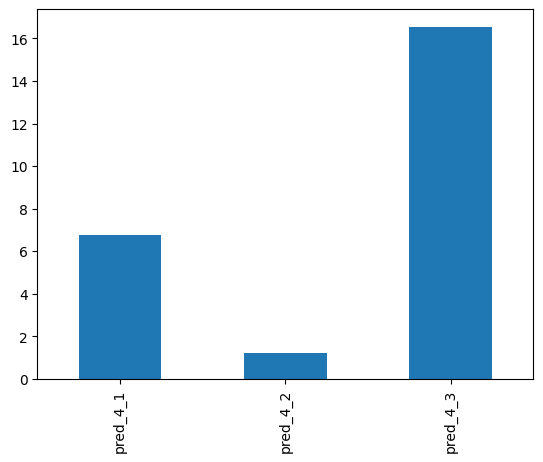

In [5]:
gov = df[df.witness_category == "Government Officials"].reset_index(drop=True)
gov.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(gov.shape[0]).multiply(100).plot(kind="bar")

### 2.2 Non-Profit Organisations

<AxesSubplot: >

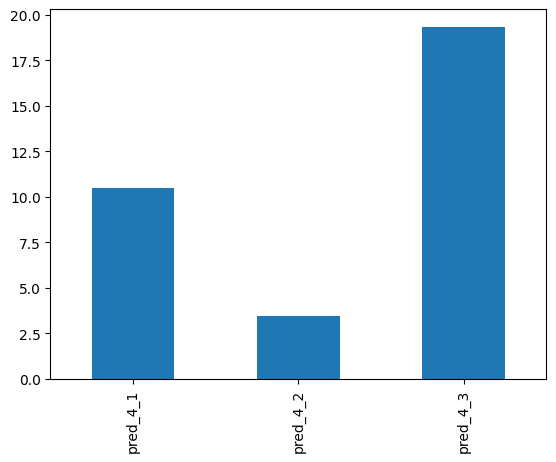

In [6]:
npo = df[df.witness_category == "Non-Profit Organisations"].reset_index(drop=True)
npo.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(npo.shape[0]).multiply(100).plot(kind="bar")

### 2.3 Scientists

<AxesSubplot: >

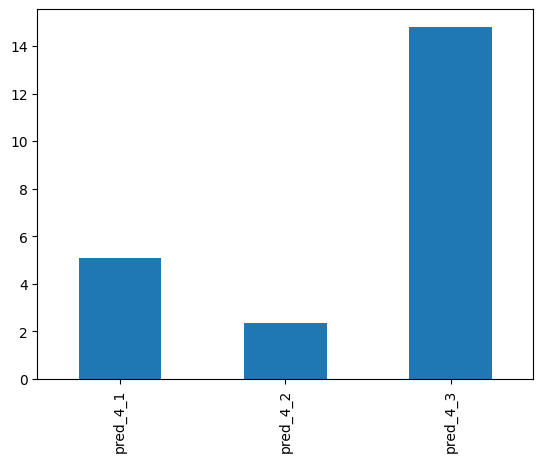

In [7]:
sci = df[df.witness_category == "Scientists"].reset_index(drop=True)
sci.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(sci.shape[0]).multiply(100).plot(kind="bar")

### 2.4 Carbon-intensive Industry

<AxesSubplot: >

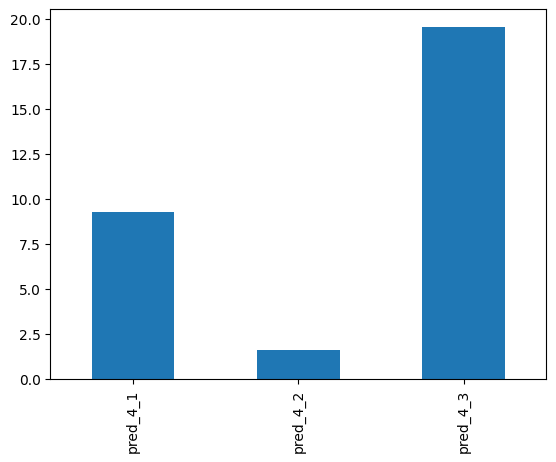

In [8]:
cii = df[df.witness_category == "Carbon-intensive Industry"].reset_index(drop=True)
cii.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(cii.shape[0]).multiply(100).plot(kind="bar")

### 2.5 Fossil Fuel Industry

<AxesSubplot: >

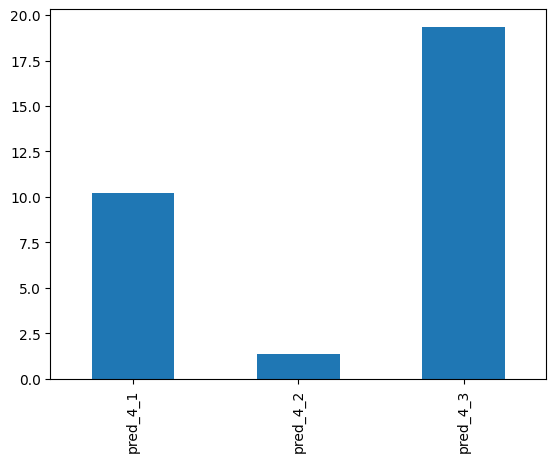

In [9]:
ffi = df[df.witness_category == "Fossil Fuel Industry"].reset_index(drop=True)
ffi.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(ffi.shape[0]).multiply(100).plot(kind="bar")

### 2.6 Business & Services

<AxesSubplot: >

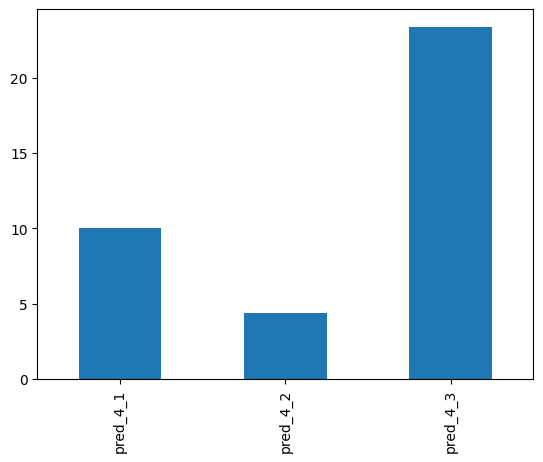

In [10]:
bas = df[df.witness_category == "Business & Services"].reset_index(drop=True)
bas.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(bas.shape[0]).multiply(100).plot(kind="bar")

### 2.7 Other

<AxesSubplot: >

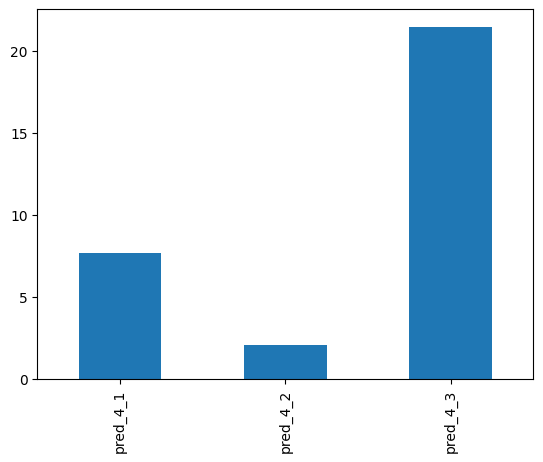

In [11]:
otr = df[df.witness_category == "Other"].reset_index(drop=True)
otr.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(otr.shape[0]).multiply(100).plot(kind="bar")

### 2.8 Alternative Energy

<AxesSubplot: >

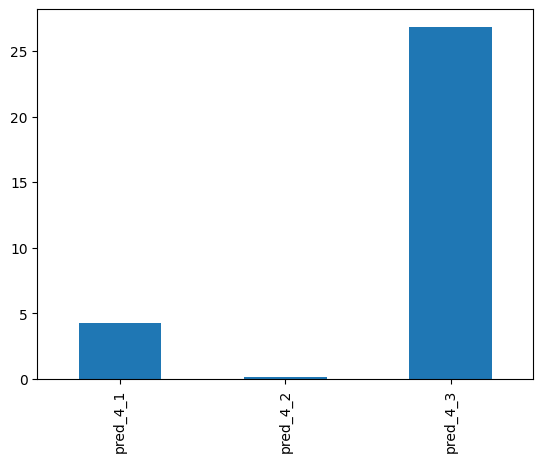

In [12]:
aen = df[df.witness_category == "Alternative Energy"].reset_index(drop=True)
aen.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(aen.shape[0]).multiply(100).plot(kind="bar")

### 2.9 Members of Congress (MoCs)

<AxesSubplot: >

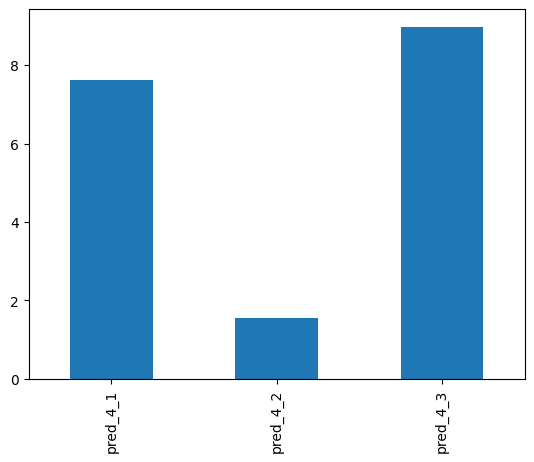

In [13]:
moc = df[df.type == "MoC"].reset_index(drop=True)
moc.loc[:, "pred_4_1":"pred_4_3"].sum(axis=0).divide(moc.shape[0]).multiply(100).plot(kind="bar")

In [14]:
moc.MoC_Party.value_counts()

D    22030
R    14917
I     1033
Name: MoC_Party, dtype: int64

<AxesSubplot: >

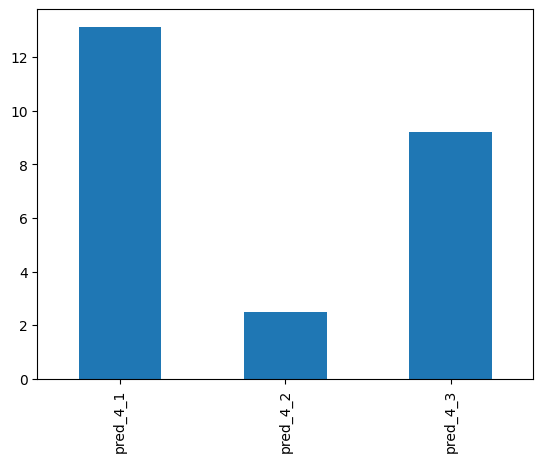

In [15]:
moc.loc[moc.MoC_Party=="R", "pred_4_1":"pred_4_3"].sum(axis=0).divide(moc.loc[moc.MoC_Party=="R"].shape[0]).multiply(100).plot(kind="bar")

<AxesSubplot: >

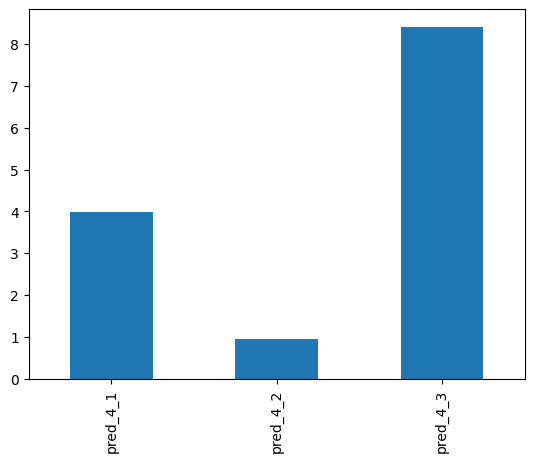

In [16]:
moc.loc[moc.MoC_Party=="D", "pred_4_1":"pred_4_3"].sum(axis=0).divide(moc.loc[moc.MoC_Party=="D"].shape[0]).multiply(100).plot(kind="bar")

## 3 Take stratified random validation samples for the relevant groups

In [17]:
# Take a stratified random sample of the FFI for validation
# We want 25 randomly selected paragraphs from each of the 4 categories
# We want to limit the data to paragraphs from witnesses that are not known contrarians
# We're adding .sample(frac=1) in the end in order to shuffle the data
# Were limiting the columns to the id, the hearing_id and the text in order to avoid biasing the validation process

ffi_sample = pd.concat([
    ffi[(ffi.pred_4 == 0) & (ffi.witness_contrarian != "Contrarian")].sample(n=25, random_state=12),
    ffi[(ffi.pred_4_1 == 1) & (ffi.witness_contrarian != "Contrarian")].sample(n=25, random_state=12),
    ffi[(ffi.pred_4_2 == 1) & (ffi.witness_contrarian != "Contrarian")].sample(n=25, random_state=12),
    ffi[(ffi.pred_4_3 == 1) & (ffi.witness_contrarian != "Contrarian")].sample(n=25, random_state=12)]).sample(frac=1,random_state=12)

# Remove the rows that have fewer than 10 words and select with two randomly sampled paragraphs with more than 10 words
# ffi_sample[ffi_sample.word_count <= 10].predicted_labels_roberta
# >> Both rows with fewer than 10 words are from the no claim category

# Subset to the rows with more than 10 words
ffi_sample = ffi_sample[ffi_sample.word_count >= 10]
# Replace the two rows with two randomly sampled no claim rows with more than 10 words that aren't yet in the sample
ffi_sample = pd.concat([
    ffi_sample,
    ffi[(ffi.pred_4 == 0) & (ffi.witness_contrarian != "Contrarian") & (ffi.word_count >= 10) & (~ffi.id.isin(ffi_sample.id))].sample(n=2, random_state=12)]).reset_index(drop=True)

# Export the data
# ffi_sample[["id", "hearing_id", "text"]].to_csv("../Data/ffi_validation_sample.csv", index=False)


In [18]:
ffi_sample[ffi_sample.id == 17324]

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L3policyclaims,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3
53,110,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2007,2007-03-20,Climate Change: Perspectives of Utility Ceos,110hhrg36921,witness,Sokol,...,None,None,None,False,0,"[0, 0, 1, 1]",1,0,1,1


In [19]:
# Take a stratified random sample of the CII data for validation
# We want 25 randomly selected paragraphs from each of the 4 categories
# We want to limit the data to paragraphs from witnesses that are not known contrarians
# We're adding .sample(frac=1) in the end in order to shuffle the data
# Were limiting the columns to the id, the hearing_id and the text in order to avoid biasing the validation process

cii_sample = pd.concat([
    cii[(cii.pred_4 == 0) & (cii.witness_contrarian != "Contrarian") & (cii.word_count >= 10)].sample(n=25, random_state=12),
    cii[(cii.pred_4_1 == 1) & (cii.witness_contrarian != "Contrarian") & (cii.word_count >= 10)].sample(n=25, random_state=12),
    cii[(cii.pred_4_2 == 1) & (cii.witness_contrarian != "Contrarian") & (cii.word_count >= 10)].sample(n=25, random_state=12),
    cii[(cii.pred_4_3 == 1) & (cii.witness_contrarian != "Contrarian") & (cii.word_count >= 10)].sample(n=25, random_state=12)]).sample(frac=1, random_state=12).reset_index(drop=True)

# Drop duplicated row
cii_sample = cii_sample[~cii_sample[["id", "hearing_id", "text"]].duplicated()]

# Add another randomly sampled 4.3 row with more than 10 words that isn't yet in the sample
cii_sample = pd.concat([
    cii_sample,
    cii[(cii.pred_4_3 == 1) & (cii.witness_contrarian != "Contrarian") & (cii.word_count >= 10)].sample(n=26, random_state=12).tail(1)]).reset_index(drop=True)

# Export the data
cii_sample[["id", "hearing_id", "text"]].to_csv("../Data/cii_validation_sample.csv", index=False)


In [20]:
cii_sample.witness_opensectrets_industry.value_counts()

Misc Manufacturing & Distributing     19
Forestry & Forest Products            15
Crop Production & Basic Processing    11
Steel Production                      10
Agricultural Services/Products         9
Automotive                             6
Air Transport                          6
Chemical & Related Manufacturing       6
Trucking                               6
Mining                                 4
Railroads                              4
Construction Services                  2
Building Materials & Equipment         1
Waste Management                       1
Name: witness_opensectrets_industry, dtype: int64

In [21]:
# Take a starticied random sample of the MoC data for validation
# We want 25 randomly selected paragraphs from each of the 4 categories for both the D and R parties

moc_sample = pd.concat([
    moc[(moc.MoC_Party=="D") & (moc.pred_4 == 0) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="D") & (moc.pred_4_1 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="D") & (moc.pred_4_2 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="D") & (moc.pred_4_3 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="R") & (moc.pred_4 == 0) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="R") & (moc.pred_4_1 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="R") & (moc.pred_4_2 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12),
    moc[(moc.MoC_Party=="R") & (moc.pred_4_3 == 1) & (moc.word_count >= 10)].sample(n=25, random_state=12)]).sample(frac=1, random_state=12).reset_index(drop=True)

# Export the data
moc_sample[["id", "hearing_id", "text"]].to_csv("../Data/moc_validation_sample.csv", index=False)

## 4 Investigate the labelled validation data

### 4.1 FFI validation

In [22]:
# Drop the contrarian rows from the ffi sample
ffi = ffi[ffi.witness_contrarian != "Contrarian"]

In [23]:
# Load the labelled FFI csv

ffi_labelled = pd.read_csv("../Data/codacat_validation_samples_ffi_labelled.csv")

# Add the no claim category to the predicted labels
# ffi_sample.predicted_labels_roberta = ffi_sample.predicted_labels_roberta.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)
ffi_labelled["labels"] = ffi_labelled[["label_4_1", "label_4_2", "label_4_3"]].values.tolist()
ffi_labelled.labels = ffi_labelled.labels.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)

ffi_labelled.head()

,id,hearing_id,text,label_4_1,label_4_2,label_4_3,labels
0,6658,109shrg28095,"And a mandatory program, in our view, is not n...",0,0,0,"[1, 0, 0, 0]"
1,61020,111shrg20182,"I think most customers, again regardless of th...",1,0,0,"[0, 1, 0, 0]"
2,364,108shrg95341,It does not. It requires implementation of pro...,0,0,0,"[1, 0, 0, 0]"
3,13795,110shrg53824,"For example, PG&E has the largest program in t...",0,0,0,"[1, 0, 0, 0]"
4,24175,110shrg61973,"First of all, globally, the Kyoto Protocol is ...",0,1,0,"[0, 0, 1, 0]"


In [24]:
# Calculate weights for the FFI sample
ffi_counts_all = (pd.DataFrame(ffi.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
ffi_counts_all["label_for_matching"] = ffi_counts_all.predicted_label.apply(lambda x: "".join([str(i) for i in x]))

ffi_counts_sample = (pd.DataFrame(ffi_sample.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
ffi_counts_sample["label_for_matching"] = ffi_counts_sample.predicted_label.apply(lambda x: "".join([str(i) for i in x]))
ffi_counts_sample = ffi_counts_sample.iloc[:,1:3]

ffi_weights = pd.merge(ffi_counts_all, ffi_counts_sample, on = "label_for_matching", how="left").fillna(value = 0)
ffi_weights = ffi_weights.drop(["label_for_matching"], axis = 1)
ffi_weights["weight"] = ffi_weights.predicted_count/ffi_weights.predicted_count_sample
ffi_weights.weight = round(ffi_weights.weight)
ffi_weights["matching_labels"] = ffi_weights.predicted_label.astype(str)
ffi_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",432,25,17.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",21,16,1.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",4,3,1.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",220,22,10.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",9,3,3.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",6,6,1.0,"[0, 1, 1, 0]"
6,"[1, 0, 0, 0]",1608,25,64.0,"[1, 0, 0, 0]"


In [25]:
# Merge the weights with the sample
ffi_sample["matching_labels"] = ffi_sample.predicted_labels_roberta.astype(str)
ffi_sample = ffi_sample.merge(ffi_weights.iloc[:, 3:5], on = "matching_labels", how="left")
ffi_sample.drop(columns=["matching_labels"], inplace=True)
ffi_sample.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight
0,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0
1,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-28,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20182,witness,Law,...,None,None,False,0,"[0, 1, 0, 0]",1,1,0,0,10.0
2,108,SENATE,"Committee on Commerce, Science, and Transporta...","Commerce, Science, and Transportation",2003,2003-01-08,Climate Change,108shrg95341,witness,Overbey,...,None,None,False,0,"[0, 0, 0, 1]",1,0,0,1,17.0
3,110,SENATE,Committee on Environment and Public Works,Environment and Public Works,2007,2007-02-13,The U.S. Climate Action Partnership Report,110shrg53824,witness,Darbee,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0
4,110,SENATE,Committee on Environment and Public Works,Environment and Public Works,2007,2007-06-28,Examining Global Warming Issues in the Power P...,110shrg61973,witness,Murray,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,1.0


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
ffi_sample_exploded = ffi_sample.loc[ffi_sample.index.repeat(ffi_sample.weight)].reset_index(drop=True)
ffi_sample_exploded = ffi_sample_exploded.merge(ffi_labelled[["id", "labels"]], on="id", how="left")
ffi_sample_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight,labels
0,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0,"[1, 0, 0, 0]"
1,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0,"[1, 0, 0, 0]"
2,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0,"[1, 0, 0, 0]"
3,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0,"[1, 0, 0, 0]"
4,109,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2006,2006-04-04,Climate Change,109shrg28095,witness,Hobson,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,64.0,"[1, 0, 0, 0]"


In [27]:
# Get the sklearn classification report for the sample FFI data
print(classification_report(ffi_labelled.labels.values.tolist(), ffi_sample.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.76      0.35      0.48        54
           1       0.45      0.78      0.57        18
           2       0.60      0.94      0.73        16
           3       0.35      0.61      0.45        18

   micro avg       0.53      0.56      0.54       106
   macro avg       0.54      0.67      0.56       106
weighted avg       0.61      0.56      0.53       106
 samples avg       0.55      0.56      0.54       106



In [28]:
# Get the sklearn classification report for the exploded sample FFI data
print(classification_report(ffi_sample_exploded.labels.values.tolist(), ffi_sample_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1590
           1       0.49      0.47      0.48       245
           2       0.60      0.19      0.29        79
           3       0.36      0.36      0.36       434

   micro avg       0.65      0.64      0.65      2348
   macro avg       0.55      0.45      0.47      2348
weighted avg       0.65      0.64      0.64      2348
 samples avg       0.66      0.66      0.66      2348



In [29]:
# Extract the classification report to a dataframe for the sample FFI data and calculate the model bias corrected predicted counts
ffi_report = pd.DataFrame(classification_report(ffi_labelled.labels.values.tolist(), 
                                                ffi_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
ffi_report["predicted_count"] = pd.DataFrame(classification_report(ffi_sample.predicted_labels_roberta.values.tolist(), ffi_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
ffi_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
ffi_report["predicted_count_corrected_P"] = round(ffi_report["predicted_count"] * ffi_report["precision"])

# Correct the predicted count with precision and recall
ffi_report["predicted_count_corrected_PR"] = round(ffi_report["predicted_count"] * ffi_report["precision"] / ffi_report["recall"])

ffi_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.760000,0.351852,0.481013,54.0,25.0,19.0,54.0
1,0.451613,0.777778,0.571429,18.0,31.0,14.0,18.0
2,0.600000,0.937500,0.731707,16.0,25.0,15.0,16.0
3,0.354839,0.611111,0.448980,18.0,31.0,11.0,18.0
micro avg,0.526786,0.556604,0.541284,106.0,112.0,59.0,106.0
macro avg,0.541613,0.669560,0.558282,106.0,112.0,61.0,91.0
weighted avg,0.614680,0.556604,0.528767,106.0,112.0,69.0,124.0
samples avg,0.545000,0.556667,0.544667,106.0,112.0,61.0,110.0


In [30]:
# Extract the classification report to a dataframe for the exploded sample FFI data and calculate the model bias corrected predicted counts
ffi_report_exploded = pd.DataFrame(classification_report(ffi_sample_exploded.labels.values.tolist(), 
                                                ffi_sample_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
ffi_report_exploded["predicted_count"] = pd.DataFrame(classification_report(ffi_sample.predicted_labels_roberta.values.tolist(), ffi_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
ffi_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

ffi_report_exploded.actual_count = ffi_report.actual_count
ffi_report_exploded


# Correct the predicted count with precision
ffi_report_exploded["predicted_count_corrected_P"] = round(ffi_report_exploded["predicted_count"] * ffi_report_exploded["precision"])

# Correct the predicted count with precision and recall
ffi_report_exploded["predicted_count_corrected_PR"] = round(ffi_report_exploded["predicted_count"] * ffi_report_exploded["precision"] / ffi_report_exploded["recall"])

ffi_report_exploded


,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.760000,0.764780,0.762382,54.0,25.0,19.0,25.0
1,0.489362,0.469388,0.479167,18.0,31.0,15.0,32.0
2,0.600000,0.189873,0.288462,16.0,25.0,15.0,79.0
3,0.359268,0.361751,0.360505,18.0,31.0,11.0,31.0
micro avg,0.654332,0.640119,0.647147,106.0,112.0,73.0,114.0
macro avg,0.552157,0.446448,0.472629,106.0,112.0,62.0,139.0
weighted avg,0.652307,0.640119,0.642603,106.0,112.0,73.0,114.0
samples avg,0.656648,0.658037,0.656926,106.0,112.0,74.0,112.0


In [31]:
# Get the binary sklearn classification report for the sample FFI data
print(classification_report([1 if sum(i)>0 else 0 for i in ffi_labelled.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in ffi_sample.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.76      0.35      0.48        54
           1       0.53      0.87      0.66        46

    accuracy                           0.59       100
   macro avg       0.65      0.61      0.57       100
weighted avg       0.66      0.59      0.56       100



In [32]:
# Get the binary sklearn classification report for the exploded sample FFI data
print(classification_report([1 if sum(i)>0 else 0 for i in ffi_sample_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in ffi_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1590
           1       0.45      0.44      0.45       689

    accuracy                           0.67      2279
   macro avg       0.60      0.60      0.60      2279
weighted avg       0.67      0.67      0.67      2279



In [33]:
ffi_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in ffi_labelled.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in ffi_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
ffi_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in ffi_sample.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in ffi_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
ffi_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
ffi_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.760000,0.351852,0.481013,54.00,25.0
1,0.533333,0.869565,0.661157,46.00,75.0
accuracy,0.590000,0.590000,0.590000,0.59,1.0
macro avg,0.646667,0.610709,0.571085,100.00,100.0
weighted avg,0.655733,0.590000,0.563879,100.00,100.0


In [34]:
ffi_report_exploded_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in ffi_sample_exploded.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in ffi_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
ffi_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in ffi_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in ffi_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
ffi_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
ffi_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.760000,0.764780,0.762382,1590.000000,1600.0
1,0.449190,0.442671,0.445906,689.000000,679.0
accuracy,0.667398,0.667398,0.667398,0.667398,1.0
macro avg,0.604595,0.603725,0.604144,2279.000000,2279.0
weighted avg,0.666034,0.667398,0.666704,2279.000000,2279.0


### 4.2 CII validation

In [35]:
# Drop the contrarian rows from the ffi sample
cii = cii[cii.witness_contrarian != "Contrarian"]

In [36]:
# Load the labelled CII csv

cii_labelled = pd.read_csv("../Data/codacat_validation_samples_cii_labelled.csv")

# Add the no claim category to the predicted labels
cii_labelled["labels"] = cii_labelled[["label_4_1", "label_4_2", "label_4_3"]].values.tolist()
cii_labelled.labels = cii_labelled.labels.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)

cii_labelled.head()

,id,hearing_id,text,label_4_1,label_4_2,label_4_3,labels
0,43375,111hhrg51949,Our international expansion has never been an ...,0,0,0,"[1, 0, 0, 0]"
1,57691,111shrg62715,"First, specialty crop growers are generally re...",0,0,0,"[1, 0, 0, 0]"
2,52496,111hhrg53787,"For the last 4 years, we have been working on ...",0,0,0,"[1, 0, 0, 0]"
3,23323,110hhrg35926,"In a normal jet engine, the fan, the compresso...",0,0,0,"[1, 0, 0, 0]"
4,19440,110shrg36310,Here we have some room for improvement of the ...,0,0,0,"[1, 0, 0, 0]"


In [37]:
# Calculate weights for the CII sample
cii_counts_all = (pd.DataFrame(cii.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
cii_counts_all["label_for_matching"] = cii_counts_all.predicted_label.apply(lambda x: "".join([str(i) for i in x]))

cii_counts_sample = (pd.DataFrame(cii_sample.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
cii_counts_sample["label_for_matching"] = cii_counts_sample.predicted_label.apply(lambda x: "".join([str(i) for i in x]))
cii_counts_sample = cii_counts_sample.iloc[:,1:3]

cii_weights = pd.merge(cii_counts_all, cii_counts_sample, on = "label_for_matching", how="left").fillna(value = 0)
cii_weights = cii_weights.drop(["label_for_matching"], axis = 1)
cii_weights["weight"] = cii_weights.predicted_count/cii_weights.predicted_count_sample
cii_weights.weight = round(cii_weights.weight)
cii_weights["matching_labels"] = cii_weights.predicted_label.astype(str)
cii_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",498,24,21.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",30,16,2.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",11,8,1.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",239,25,10.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",3,1,3.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",1,1,1.0,"[0, 1, 1, 0]"
6,"[1, 0, 0, 0]",1836,25,73.0,"[1, 0, 0, 0]"


In [38]:
# Merge the weights with the sample
cii_sample["matching_labels"] = cii_sample.predicted_labels_roberta.astype(str)
cii_sample = cii_sample.merge(cii_weights.iloc[:, 3:5], on = "matching_labels", how="left")
cii_sample.drop(columns=["matching_labels"], inplace=True)
cii_sample.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight
0,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0
1,111,SENATE,"Committee on Agriculture, Nutrition, and Forestry","Agriculture, Nutrition, and Forestry",2009,2009-09-09,Global Warming Legislation: Carbon Markets and...,111shrg62715,witness,Beckstoffer,...,None,None,False,0,"[0, 1, 0, 0]",1,1,0,0,10.0
2,111,HOUSE,Committee on Agriculture,Agriculture,2009,2009-06-11,Hearing to Review Pending Climate Legislation,111hhrg53787,witness,Yoder,...,None,None,False,0,"[0, 0, 0, 1]",1,0,0,1,21.0
3,110,HOUSE,Committee on Transportation and Infrastructure,Transportation and Infrastructure,2007,2007-05-11,Administration Proposals on Climate Change and...,110hhrg35926,witness,McQuade,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0
4,110,SENATE,Committee on Energy and Natural Resources,Energy and Natural Resources,2007,2007-03-26,Eu Emissions,110shrg36310,witness,Vanderborght,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,2.0


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
cii_sample_exploded = cii_sample.loc[cii_sample.index.repeat(cii_sample.weight)].reset_index(drop=True)
cii_sample_exploded = cii_sample_exploded.merge(cii_labelled[["id", "labels"]], on="id", how="left")
cii_sample_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight,labels
0,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0,"[1, 0, 0, 0]"
1,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0,"[1, 0, 0, 0]"
2,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0,"[1, 0, 0, 0]"
3,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0,"[1, 0, 0, 0]"
4,111,HOUSE,Committee on Ways and Means,Ways and Means,2009,2009-03-24,Hearing on Trade Aspects of Climate Change Leg...,111hhrg51949,witness,Clay,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,73.0,"[1, 0, 0, 0]"


In [40]:
# Get the sklearn classification report for the sample CII data
print(classification_report(cii_labelled.labels.values.tolist(), cii_sample.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50        76
           1       0.63      0.85      0.72        20
           2       0.16      0.67      0.26         6
           3       0.03      0.33      0.06         3

   micro avg       0.43      0.45      0.44       105
   macro avg       0.45      0.54      0.38       105
weighted avg       0.85      0.45      0.51       105
 samples avg       0.46      0.45      0.45       105



In [41]:
# Get the sklearn classification report for the exploded sample CII data
print(classification_report(cii_sample_exploded.labels.values.tolist(), cii_sample_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      2430
           1       0.63      0.97      0.77       166
           2       0.17      0.26      0.21        27
           3       0.04      0.64      0.08        33

   micro avg       0.76      0.76      0.76      2656
   macro avg       0.46      0.65      0.48      2656
weighted avg       0.96      0.76      0.84      2656
 samples avg       0.77      0.76      0.76      2656



In [42]:
# Extract the classification report to a dataframe for the sample CII data and calculate the model bias corrected predicted counts
cii_report = pd.DataFrame(classification_report(cii_labelled.labels.values.tolist(), 
                                                cii_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
cii_report["predicted_count"] = pd.DataFrame(classification_report(cii_sample.predicted_labels_roberta.values.tolist(), cii_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
cii_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
cii_report["predicted_count_corrected_P"] = round(cii_report["predicted_count"] * cii_report["precision"])

# Correct the predicted count with precision and recall
cii_report["predicted_count_corrected_PR"] = round(cii_report["predicted_count"] * cii_report["precision"] / cii_report["recall"])

cii_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,1.000000,0.328947,0.495050,76.0,25.0,25.0,76.0
1,0.629630,0.850000,0.723404,20.0,27.0,17.0,20.0
2,0.160000,0.666667,0.258065,6.0,25.0,4.0,6.0
3,0.030303,0.333333,0.055556,3.0,33.0,1.0,3.0
micro avg,0.427273,0.447619,0.437209,105.0,110.0,47.0,105.0
macro avg,0.454983,0.544737,0.383018,105.0,110.0,50.0,92.0
weighted avg,0.853748,0.447619,0.512447,105.0,110.0,94.0,210.0
samples avg,0.460000,0.448333,0.450000,105.0,110.0,51.0,113.0


In [43]:
# Extract the classification report to a dataframe for the exploded sample CII data and calculate the model bias corrected predicted counts
cii_report_exploded = pd.DataFrame(classification_report(cii_sample_exploded.labels.values.tolist(), 
                                                cii_sample_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
cii_report_exploded["predicted_count"] = pd.DataFrame(classification_report(cii_sample.predicted_labels_roberta.values.tolist(), cii_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
cii_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

cii_report_exploded.actual_count = cii_report.actual_count
cii_report_exploded


# Correct the predicted count with precision
cii_report_exploded["predicted_count_corrected_P"] = round(cii_report_exploded["predicted_count"] * cii_report_exploded["precision"])

# Correct the predicted count with precision and recall
cii_report_exploded["predicted_count_corrected_PR"] = round(cii_report_exploded["predicted_count"] * cii_report_exploded["precision"] / cii_report_exploded["recall"])

cii_report_exploded


,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,1.000000,0.751029,0.857814,76.0,25.0,25.0,33.0
1,0.633858,0.969880,0.766667,20.0,27.0,17.0,18.0
2,0.170732,0.259259,0.205882,6.0,25.0,4.0,16.0
3,0.040777,0.636364,0.076642,3.0,33.0,1.0,2.0
micro avg,0.764326,0.758283,0.761293,105.0,110.0,84.0,111.0
macro avg,0.461342,0.654133,0.476751,105.0,110.0,51.0,78.0
weighted avg,0.956768,0.758283,0.835784,105.0,110.0,105.0,139.0
samples avg,0.767442,0.762803,0.764074,105.0,110.0,84.0,111.0


In [44]:
# Get the binary sklearn classification report for the sample CII data
print(classification_report([1 if sum(i)>0 else 0 for i in cii_labelled.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in cii_sample.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50        76
           1       0.32      1.00      0.48        24

    accuracy                           0.49       100
   macro avg       0.66      0.66      0.49       100
weighted avg       0.84      0.49      0.49       100



In [45]:
# Get the binary sklearn classification report for the exploded sample CII data
print(classification_report([1 if sum(i)>0 else 0 for i in cii_sample_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in cii_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      2430
           1       0.24      1.00      0.39       193

    accuracy                           0.77      2623
   macro avg       0.62      0.88      0.62      2623
weighted avg       0.94      0.77      0.82      2623



In [46]:
cii_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in cii_labelled.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in cii_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
cii_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in cii_sample.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in cii_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
cii_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
cii_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,1.0000,0.328947,0.495050,76.00,25.0
1,0.3200,1.000000,0.484848,24.00,75.0
accuracy,0.4900,0.490000,0.490000,0.49,1.0
macro avg,0.6600,0.664474,0.489949,100.00,100.0
weighted avg,0.8368,0.490000,0.492601,100.00,100.0


In [47]:
cii_report_exploded_binary = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in cii_sample_exploded.labels.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in cii_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
cii_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in cii_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in cii_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
cii_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
cii_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,1.000000,0.751029,0.857814,2430.000000,1825.0
1,0.241855,1.000000,0.389506,193.000000,798.0
accuracy,0.769348,0.769348,0.769348,0.769348,1.0
macro avg,0.620927,0.875514,0.623660,2623.000000,2623.0
weighted avg,0.944216,0.769348,0.823356,2623.000000,2623.0


### 4.3 MOC validation

In [48]:
# Load the labelled MOC csv

moc_labelled = pd.read_csv("../Data/codacat_validation_samples_moc_labelled.csv")

# Add the no claim category to the predicted labels
moc_labelled["labels"] = moc_labelled[["label_4_1", "label_4_2", "label_4_3"]].values.tolist()
moc_labelled.labels = moc_labelled.labels.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)

moc_labelled.head()

,id,hearing_id,text,label_4_1,label_4_2,label_4_3,labels
0,62166,111shrg20183,OK. Senator Alexander is such a strong advocat...,0,0,0,"[1, 0, 0, 0]"
1,28698,110shrg44771,"Now, I go through all of this rhetoric simply ...",0,0,0,"[1, 0, 0, 0]"
2,46581,111hhrg72878,Do you think China is going by the cash register?,0,0,0,"[1, 0, 0, 0]"
3,40708,111hhrg67096,And we thank all of you for your excellent tes...,0,0,0,"[1, 0, 0, 0]"
4,25051,110hhrg58149,The policies we adopt will have global impacts...,0,0,0,"[1, 0, 0, 0]"


In [49]:
# Calculate weights for the MOC sample
moc_counts_all = (pd.DataFrame(moc.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
moc_counts_all["label_for_matching"] = moc_counts_all.predicted_label.apply(lambda x: "".join([str(i) for i in x]))

moc_counts_sample = (pd.DataFrame(moc_sample.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
moc_counts_sample["label_for_matching"] = moc_counts_sample.predicted_label.apply(lambda x: "".join([str(i) for i in x]))
moc_counts_sample = moc_counts_sample.iloc[:,1:3]

moc_weights = pd.merge(moc_counts_all, moc_counts_sample, on = "label_for_matching", how="left").fillna(value = 0)
moc_weights = moc_weights.drop(["label_for_matching"], axis = 1)
moc_weights["weight"] = moc_weights.predicted_count/moc_weights.predicted_count_sample
moc_weights.weight = round(moc_weights.weight)
moc_weights["matching_labels"] = moc_weights.predicted_label.astype(str)
moc_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",3190,46.0,69.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",456,37.0,12.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",67,10.0,7.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",2675,47.0,57.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",156,4.0,39.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",68,6.0,11.0,"[0, 1, 1, 0]"
6,"[0, 1, 1, 1]",2,0.0,inf,"[0, 1, 1, 1]"
7,"[1, 0, 0, 0]",31435,50.0,629.0,"[1, 0, 0, 0]"


In [50]:
# Drop the [0, 1, 1, 1] predictions as this seems to be extremely rare, even in the predictions an inexistent in the labelled data and a weight of inf will bias the data

moc_weights = moc_weights.drop([6]).reset_index(drop = True)

In [51]:
# Merge the weights with the sample
moc_sample["matching_labels"] = moc_sample.predicted_labels_roberta.astype(str)
moc_sample = moc_sample.merge(moc_weights.iloc[:, 3:5], on = "matching_labels", how="left")
moc_sample.drop(columns=["matching_labels"], inplace=True)
moc_sample.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight
0,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0
1,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,None,False,0,"[0, 0, 0, 1]",1,0,0,1,69.0
2,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-04-21,The American Clean Energy Security Act of 2009,111hhrg72878,MoC,Hall,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,12.0
3,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-03-05,The Role of Offsets in Climate Legislation,111hhrg67096,MoC,Markey,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0
4,110,HOUSE,Select Committee on Energy Independence and Gl...,Energy Independence and Global Warming,2007,2007-09-06,The Future of Coal Under Carbon Cap and Trade,110hhrg58149,MoC,Markey,...,None,None,False,0,"[0, 0, 1, 1]",1,0,1,1,7.0


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
moc_sample_exploded = moc_sample.loc[moc_sample.index.repeat(moc_sample.weight)].reset_index(drop=True)
moc_sample_exploded = moc_sample_exploded.merge(moc_labelled[["id", "labels"]], on="id", how="left")
moc_sample_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight,labels
0,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0,"[1, 0, 0, 0]"
1,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0,"[1, 0, 0, 0]"
2,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0,"[1, 0, 0, 0]"
3,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0,"[1, 0, 0, 0]"
4,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,629.0,"[1, 0, 0, 0]"


In [53]:
# Get the sklearn classification report for the sample MOC data
print(classification_report(moc_labelled.labels.values.tolist(),
                            moc_sample.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.36      0.52       133
           1       0.51      0.83      0.63        35
           2       0.38      0.83      0.52        24
           3       0.18      0.79      0.30        14

   micro avg       0.49      0.52      0.51       206
   macro avg       0.51      0.70      0.49       206
weighted avg       0.76      0.52      0.53       206
 samples avg       0.52      0.52      0.52       206



In [54]:
# Get the sklearn classification report for the exploded sample MOC data
print(classification_report(moc_sample_exploded.labels.values.tolist(),
                            moc_sample_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     34008
           1       0.52      0.51      0.52      2912
           2       0.38      0.49      0.43       451
           3       0.22      0.86      0.35       885

   micro avg       0.85      0.85      0.85     38256
   macro avg       0.52      0.69      0.56     38256
weighted avg       0.90      0.85      0.87     38256
 samples avg       0.86      0.86      0.86     38256



In [55]:
# Extract the classification report to a dataframe for the sample MOC data and calculate the model bias corrected predicted counts
moc_report = pd.DataFrame(classification_report(moc_labelled.labels.values.tolist(), 
                                                moc_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
moc_report["predicted_count"] = pd.DataFrame(classification_report(moc_sample.predicted_labels_roberta.values.tolist(), moc_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
moc_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
moc_report["predicted_count_corrected_P"] = round(moc_report["predicted_count"] * moc_report["precision"])

# Correct the predicted count with precision and recall
moc_report["predicted_count_corrected_PR"] = round(moc_report["predicted_count"] * moc_report["precision"] / moc_report["recall"])

moc_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.360902,0.524590,133.0,50.0,48.0,133.0
1,0.508772,0.828571,0.630435,35.0,57.0,29.0,35.0
2,0.377358,0.833333,0.519481,24.0,53.0,20.0,24.0
3,0.183333,0.785714,0.297297,14.0,60.0,11.0,14.0
micro avg,0.490909,0.524272,0.507042,206.0,220.0,108.0,206.0
macro avg,0.507366,0.702130,0.492951,206.0,220.0,112.0,159.0
weighted avg,0.762671,0.524272,0.526531,206.0,220.0,168.0,320.0
samples avg,0.517500,0.520000,0.515000,206.0,220.0,114.0,219.0


In [56]:
# Extract the classification report to a dataframe for the exploded sample MOC data and calculate the model bias corrected predicted counts
moc_report_exploded = pd.DataFrame(classification_report(moc_sample_exploded.labels.values.tolist(), 
                                                moc_sample_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
moc_report_exploded["predicted_count"] = pd.DataFrame(classification_report(moc_sample.predicted_labels_roberta.values.tolist(), moc_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
moc_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

moc_report_exploded.actual_count = moc_report.actual_count
moc_report_exploded


# Correct the predicted count with precision
moc_report_exploded["predicted_count_corrected_P"] = round(moc_report_exploded["predicted_count"] * moc_report_exploded["precision"])

# Correct the predicted count with precision and recall
moc_report_exploded["predicted_count_corrected_PR"] = round(moc_report_exploded["predicted_count"] * moc_report_exploded["precision"] / moc_report_exploded["recall"])

moc_report_exploded

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.887791,0.922485,133.0,50.0,48.0,54.0
1,0.516029,0.514080,0.515052,35.0,57.0,29.0,57.0
2,0.384483,0.494457,0.432590,24.0,53.0,20.0,41.0
3,0.223235,0.857627,0.354259,14.0,60.0,13.0,16.0
micro avg,0.852339,0.854010,0.853174,206.0,220.0,188.0,220.0
macro avg,0.520937,0.688489,0.556096,206.0,220.0,115.0,166.0
weighted avg,0.902377,0.854010,0.872551,206.0,220.0,199.0,232.0
samples avg,0.857370,0.855740,0.855972,206.0,220.0,189.0,220.0


In [57]:
# Get the binary sklearn classification report for the sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in moc_labelled.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in moc_sample.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.36      0.52       133
           1       0.43      0.97      0.60        67

    accuracy                           0.56       200
   macro avg       0.70      0.67      0.56       200
weighted avg       0.78      0.56      0.55       200



In [58]:
# Get the binary sklearn classification report for the exploded sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in moc_sample_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in moc_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     34008
           1       0.42      0.69      0.52      4031

    accuracy                           0.87     38039
   macro avg       0.69      0.79      0.72     38039
weighted avg       0.90      0.87      0.88     38039



In [59]:
moc_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in moc_labelled.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in moc_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
moc_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in moc_sample.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in moc_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
moc_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
moc_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.360902,0.524590,133.000,50.0
1,0.433333,0.970149,0.599078,67.000,150.0
accuracy,0.565000,0.565000,0.565000,0.565,1.0
macro avg,0.696667,0.665526,0.561834,200.000,200.0
weighted avg,0.783567,0.565000,0.549544,200.000,200.0


In [60]:
moc_report_exploded_binary = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in moc_sample_exploded.labels.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in moc_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
moc_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in moc_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in moc_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
moc_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
moc_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.887791,0.922485,34008.000000,31450.0
1,0.420853,0.687919,0.522222,4031.000000,6589.0
accuracy,0.866611,0.866611,0.866611,0.866611,1.0
macro avg,0.690426,0.787855,0.722353,38039.000000,38039.0
weighted avg,0.902866,0.866611,0.880069,38039.000000,38039.0


### 4.3.1 MOC validation - Democrats

In [61]:
# Subset the democratic MOC data

# All
dems = moc[moc.MoC_Party == "D"]

# Sample
dems_sample = moc_sample[moc_sample.id.isin(dems.id)]
dems_sample = dems_sample.drop(["weight"], axis = 1)

# Labelled
dems_labelled = moc_labelled[moc_labelled.id.isin(dems.id)]

In [62]:
# Calculate weights for the democratic MOC sample
dems_counts_all = (pd.DataFrame(dems.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
dems_counts_all["label_for_matching"] = dems_counts_all.predicted_label.apply(lambda x: "".join([str(i) for i in x]))

dems_counts_sample = (pd.DataFrame(dems_sample.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
dems_counts_sample["label_for_matching"] = dems_counts_sample.predicted_label.apply(lambda x: "".join([str(i) for i in x]))
dems_counts_sample = dems_counts_sample.iloc[:,1:3]

dems_weights = pd.merge(dems_counts_all, dems_counts_sample, on = "label_for_matching", how="left").fillna(value = 0)
dems_weights = dems_weights.drop(["label_for_matching"], axis = 1)
dems_weights["weight"] = dems_weights.predicted_count/dems_weights.predicted_count_sample
dems_weights.weight = round(dems_weights.weight)
dems_weights["matching_labels"] = dems_weights.predicted_label.astype(str)
dems_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",1740,23.0,76.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",174,18.0,10.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",28,7.0,4.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",787,23.0,34.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",83,2.0,42.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",9,2.0,4.0,"[0, 1, 1, 0]"
6,"[0, 1, 1, 1]",1,0.0,inf,"[0, 1, 1, 1]"
7,"[1, 0, 0, 0]",19208,25.0,768.0,"[1, 0, 0, 0]"


In [63]:
# Drop the [0, 1, 1, 1] predictions as this seems to be extremely rare, even in the predictions an inexistent in the labelled data and a weight of inf will bias the data

dems_weights = dems_weights.drop([6]).reset_index(drop = True)

In [64]:
# Merge the weights with the sample
dems_sample["matching_labels"] = dems_sample.predicted_labels_roberta.astype(str)
dems_sample = dems_sample.merge(dems_weights.iloc[:, 3:5], on = "matching_labels", how="left")
dems_sample.drop(columns=["matching_labels"], inplace=True)
dems_sample.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight
0,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0
1,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-03-05,The Role of Offsets in Climate Legislation,111hhrg67096,MoC,Markey,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0
2,110,HOUSE,Select Committee on Energy Independence and Gl...,Energy Independence and Global Warming,2007,2007-09-06,The Future of Coal Under Carbon Cap and Trade,110hhrg58149,MoC,Markey,...,None,None,False,0,"[0, 0, 1, 1]",1,0,1,1,4.0
3,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-04-21,The American Clean Energy Security Act of 2009,111hhrg72878,MoC,Markey,...,None,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0
4,110,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2008,2008-06-26,Hearing on Climate Change: Costs of Inaction,110hhrg57595,MoC,Boucher,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,10.0


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
dems_sample_exploded = dems_sample.loc[dems_sample.index.repeat(dems_sample.weight)].reset_index(drop=True)
dems_sample_exploded = dems_sample_exploded.merge(dems_labelled[["id", "labels"]], on="id", how="left")
dems_sample_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight,labels
0,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0,"[1, 0, 0, 0]"
1,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0,"[1, 0, 0, 0]"
2,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0,"[1, 0, 0, 0]"
3,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0,"[1, 0, 0, 0]"
4,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-10-29,"Legislative Hearing on S. 1733, Clean Energy J...",111shrg20183,MoC,Boxer,...,None,False,0,"[1, 0, 0, 0]",0,0,0,0,768.0,"[1, 0, 0, 0]"


In [66]:
# Get the sklearn classification report for the sample MOC data
print(classification_report(dems_labelled.labels.values.tolist(),
                            dems_sample.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.30      0.46        80
           1       0.26      0.78      0.39         9
           2       0.15      0.80      0.25         5
           3       0.16      0.83      0.26         6

   micro avg       0.36      0.40      0.38       100
   macro avg       0.38      0.68      0.34       100
weighted avg       0.81      0.40      0.43       100
 samples avg       0.40      0.40      0.40       100



In [67]:
# Get the sklearn classification report for the exploded sample MOC data
print(classification_report(dems_sample_exploded.labels.values.tolist(),
                            dems_sample_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     20466
           1       0.27      0.22      0.24      1082
           2       0.16      0.50      0.24        68
           3       0.20      0.92      0.33       414

   micro avg       0.86      0.87      0.86     22030
   macro avg       0.40      0.63      0.44     22030
weighted avg       0.91      0.87      0.88     22030
 samples avg       0.87      0.87      0.87     22030



In [68]:
# Extract the classification report to a dataframe for the sample MOC data and calculate the model bias corrected predicted counts
dems_report = pd.DataFrame(classification_report(dems_labelled.labels.values.tolist(), 
                                                dems_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
dems_report["predicted_count"] = pd.DataFrame(classification_report(dems_sample.predicted_labels_roberta.values.tolist(), dems_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
dems_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
dems_report["predicted_count_corrected_P"] = round(dems_report["predicted_count"] * dems_report["precision"])

# Correct the predicted count with precision and recall
dems_report["predicted_count_corrected_PR"] = round(dems_report["predicted_count"] * dems_report["precision"] / dems_report["recall"])

dems_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.300000,0.457143,80.0,25.0,24.0,80.0
1,0.259259,0.777778,0.388889,9.0,27.0,7.0,9.0
2,0.148148,0.800000,0.250000,5.0,27.0,4.0,5.0
3,0.156250,0.833333,0.263158,6.0,32.0,5.0,6.0
micro avg,0.360360,0.400000,0.379147,100.0,111.0,40.0,100.0
macro avg,0.380914,0.677778,0.339797,100.0,111.0,42.0,62.0
weighted avg,0.808116,0.400000,0.429004,100.0,111.0,90.0,224.0
samples avg,0.395000,0.400000,0.396667,100.0,111.0,44.0,110.0


In [69]:
# Extract the classification report to a dataframe for the exploded sample MOC data and calculate the model bias corrected predicted counts
dems_report_exploded = pd.DataFrame(classification_report(dems_sample_exploded.labels.values.tolist(), 
                                                dems_sample_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
dems_report_exploded["predicted_count"] = pd.DataFrame(classification_report(dems_sample.predicted_labels_roberta.values.tolist(), dems_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
dems_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

dems_report_exploded.actual_count = dems_report.actual_count
dems_report_exploded


# Correct the predicted count with precision
dems_report_exploded["predicted_count_corrected_P"] = round(dems_report_exploded["predicted_count"] * dems_report_exploded["precision"])

# Correct the predicted count with precision and recall
dems_report_exploded["predicted_count_corrected_PR"] = round(dems_report_exploded["predicted_count"] * dems_report_exploded["precision"] / dems_report_exploded["recall"])

dems_report_exploded

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.900616,0.929360,80.0,25.0,24.0,27.0
1,0.272311,0.219963,0.243354,9.0,27.0,7.0,33.0
2,0.157407,0.500000,0.239437,5.0,27.0,4.0,8.0
3,0.204301,0.917874,0.334213,6.0,32.0,7.0,7.0
micro avg,0.861580,0.866273,0.863920,100.0,111.0,96.0,110.0
macro avg,0.398505,0.634613,0.436591,100.0,111.0,44.0,70.0
weighted avg,0.909545,0.866273,0.882353,100.0,111.0,101.0,117.0
samples avg,0.866182,0.866273,0.866213,100.0,111.0,96.0,111.0


In [70]:
# Get the binary sklearn classification report for the sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in dems_labelled.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in dems_sample.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.30      0.46        80
           1       0.25      0.95      0.40        20

    accuracy                           0.43       100
   macro avg       0.61      0.62      0.43       100
weighted avg       0.82      0.43      0.45       100



In [71]:
# Get the binary sklearn classification report for the exploded sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in dems_sample_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in dems_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     20466
           1       0.28      0.51      0.36      1564

    accuracy                           0.87     22030
   macro avg       0.62      0.70      0.65     22030
weighted avg       0.91      0.87      0.89     22030



In [72]:
dems_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in dems_labelled.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in dems_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
dems_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in dems_sample.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in dems_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
dems_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
dems_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.300,0.457143,80.00,25.0
1,0.253333,0.950,0.400000,20.00,75.0
accuracy,0.430000,0.430,0.430000,0.43,1.0
macro avg,0.606667,0.625,0.428571,100.00,100.0
weighted avg,0.818667,0.430,0.445714,100.00,100.0


In [73]:
dems_report_exploded_binary = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in dems_sample_exploded.labels.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in dems_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
dems_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in dems_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in dems_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
dems_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
dems_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.900616,0.929360,20466.00000,19200.0
1,0.281272,0.508951,0.362312,1564.00000,2830.0
accuracy,0.872810,0.872810,0.872810,0.87281,1.0
macro avg,0.620636,0.704784,0.645836,22030.00000,22030.0
weighted avg,0.911814,0.872810,0.889103,22030.00000,22030.0


### 4.3.2 MOC validation - Republicans

In [74]:
# Subset the republican MOC data

# All
reps = moc[moc.MoC_Party == "R"]

# Sample
reps_sample = moc_sample[moc_sample.id.isin(reps.id)]
reps_sample = reps_sample.drop(["weight"], axis = 1)

# Labelled
reps_labelled = moc_labelled[moc_labelled.id.isin(reps.id)]

In [75]:
# Calculate weights for the republican MOC sample
reps_counts_all = (pd.DataFrame(reps.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
reps_counts_all["label_for_matching"] = reps_counts_all.predicted_label.apply(lambda x: "".join([str(i) for i in x]))

reps_counts_sample = (pd.DataFrame(reps_sample.predicted_labels_roberta.value_counts()).
     rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).
     reset_index().
     rename(columns={"index": "predicted_label"}).
     sort_values(by="predicted_label").
     reset_index(drop=True))
reps_counts_sample["label_for_matching"] = reps_counts_sample.predicted_label.apply(lambda x: "".join([str(i) for i in x]))
reps_counts_sample = reps_counts_sample.iloc[:,1:3]

reps_weights = pd.merge(reps_counts_all, reps_counts_sample, on = "label_for_matching", how="left").fillna(value = 0)
reps_weights = reps_weights.drop(["label_for_matching"], axis = 1)
reps_weights["weight"] = reps_weights.predicted_count/reps_weights.predicted_count_sample
reps_weights.weight = round(reps_weights.weight)
reps_weights["matching_labels"] = reps_weights.predicted_label.astype(str)
reps_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",1270,23.0,55.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",277,19.0,15.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",38,3.0,13.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",1836,24.0,76.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",63,2.0,32.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",59,4.0,15.0,"[0, 1, 1, 0]"
6,"[0, 1, 1, 1]",1,0.0,inf,"[0, 1, 1, 1]"
7,"[1, 0, 0, 0]",11373,25.0,455.0,"[1, 0, 0, 0]"


In [76]:
# Drop the [0, 1, 1, 1] predictions as this seems to be extremely rare, even in the predictions an inexistent in the labelled data and a weight of inf will bias the data

reps_weights = reps_weights.drop([6]).reset_index(drop = True)

In [77]:
# Merge the weights with the sample
reps_sample["matching_labels"] = reps_sample.predicted_labels_roberta.astype(str)
reps_sample = reps_sample.merge(reps_weights.iloc[:, 3:5], on = "matching_labels", how="left")
reps_sample.drop(columns=["matching_labels"], inplace=True)
reps_sample.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight
0,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0
1,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-04-21,The American Clean Energy Security Act of 2009,111hhrg72878,MoC,Hall,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,15.0
2,110,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2008,2008-06-19,Legislative Proposals to Reduce Greenhouse Gas...,110hhrg56980,MoC,Barton,...,None,None,False,0,"[0, 1, 1, 0]",1,1,1,0,15.0
3,111,HOUSE,Committee on Energy and Commerce,Energy and Commerce,2009,2009-03-05,The Role of Offsets in Climate Legislation,111hhrg67096,MoC,Barton,...,None,None,False,0,"[0, 0, 1, 0]",1,0,1,0,15.0
4,111,SENATE,Committee on Environment and Public Works,Environment and Public Works,2009,2009-07-16,Ensuring and Enhancing U.S. Competitiveness Wh...,111shrg95163,MoC,Bond,...,None,None,False,0,"[0, 1, 0, 0]",1,1,0,0,76.0


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
reps_sample_exploded = reps_sample.loc[reps_sample.index.repeat(reps_sample.weight)].reset_index(drop=True)
reps_sample_exploded = reps_sample_exploded.merge(reps_labelled[["id", "labels"]], on="id", how="left")
reps_sample_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,weight,labels
0,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0,"[1, 0, 0, 0]"
1,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0,"[1, 0, 0, 0]"
2,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0,"[1, 0, 0, 0]"
3,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0,"[1, 0, 0, 0]"
4,110,SENATE,Committee on Foreign Relations,Foreign Relations,2007,2007-11-13,International Climate Change Negotiations: Res...,110shrg44771,MoC,Lugar,...,None,False,0,"[0, 0, 0, 1]",1,0,0,1,55.0,"[1, 0, 0, 0]"


In [79]:
# Get the sklearn classification report for the sample MOC data
print(classification_report(reps_labelled.labels.values.tolist(),
                            reps_sample.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.45      0.62        53
           1       0.73      0.85      0.79        26
           2       0.62      0.84      0.71        19
           3       0.21      0.75      0.33         8

   micro avg       0.62      0.64      0.63       106
   macro avg       0.63      0.72      0.61       106
weighted avg       0.79      0.64      0.65       106
 samples avg       0.64      0.64      0.63       106



In [80]:
# Get the sklearn classification report for the exploded sample MOC data
print(classification_report(reps_sample_exploded.labels.values.tolist(),
                            reps_sample_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     12296
           1       0.74      0.73      0.74      1983
           2       0.61      0.51      0.56       464
           3       0.24      0.78      0.37       421

   micro avg       0.86      0.85      0.86     15164
   macro avg       0.64      0.73      0.65     15164
weighted avg       0.90      0.85      0.87     15164
 samples avg       0.86      0.86      0.86     15164



In [81]:
# Extract the classification report to a dataframe for the sample MOC data and calculate the model bias corrected predicted counts
reps_report = pd.DataFrame(classification_report(reps_labelled.labels.values.tolist(), 
                                                reps_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
reps_report["predicted_count"] = pd.DataFrame(classification_report(reps_sample.predicted_labels_roberta.values.tolist(), reps_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
reps_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
reps_report["predicted_count_corrected_P"] = round(reps_report["predicted_count"] * reps_report["precision"])

# Correct the predicted count with precision and recall
reps_report["predicted_count_corrected_PR"] = round(reps_report["predicted_count"] * reps_report["precision"] / reps_report["recall"])

reps_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.452830,0.615385,53.0,25.0,24.0,53.0
1,0.733333,0.846154,0.785714,26.0,30.0,22.0,26.0
2,0.615385,0.842105,0.711111,19.0,26.0,16.0,19.0
3,0.214286,0.750000,0.333333,8.0,28.0,6.0,8.0
micro avg,0.623853,0.641509,0.632558,106.0,109.0,68.0,106.0
macro avg,0.630751,0.722772,0.611386,106.0,109.0,69.0,95.0
weighted avg,0.786352,0.641509,0.653035,106.0,109.0,86.0,134.0
samples avg,0.640000,0.640000,0.633333,106.0,109.0,70.0,109.0


In [82]:
# Extract the classification report to a dataframe for the exploded sample MOC data and calculate the model bias corrected predicted counts
reps_report_exploded = pd.DataFrame(classification_report(reps_sample_exploded.labels.values.tolist(), 
                                                reps_sample_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
reps_report_exploded["predicted_count"] = pd.DataFrame(classification_report(reps_sample.predicted_labels_roberta.values.tolist(), reps_sample.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
reps_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

reps_report_exploded.actual_count = reps_report.actual_count
reps_report_exploded


# Correct the predicted count with precision
reps_report_exploded["predicted_count_corrected_P"] = round(reps_report_exploded["predicted_count"] * reps_report_exploded["precision"])

# Correct the predicted count with precision and recall
reps_report_exploded["predicted_count_corrected_PR"] = round(reps_report_exploded["predicted_count"] * reps_report_exploded["precision"] / reps_report_exploded["recall"])

reps_report_exploded

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.888094,0.922648,53.0,25.0,24.0,27.0
1,0.741786,0.728694,0.735182,26.0,30.0,22.0,31.0
2,0.614583,0.508621,0.556604,19.0,26.0,16.0,31.0
3,0.241228,0.783848,0.368921,8.0,28.0,7.0,9.0
micro avg,0.857778,0.852743,0.855253,106.0,109.0,93.0,110.0
macro avg,0.639399,0.727314,0.645839,106.0,109.0,70.0,96.0
weighted avg,0.900939,0.852743,0.871559,106.0,109.0,98.0,115.0
samples avg,0.862694,0.857698,0.858548,106.0,109.0,94.0,110.0


In [83]:
# Get the binary sklearn classification report for the sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in reps_labelled.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in reps_sample.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.45      0.62        53
           1       0.61      0.98      0.75        47

    accuracy                           0.70       100
   macro avg       0.79      0.72      0.68       100
weighted avg       0.80      0.70      0.68       100



In [84]:
# Get the binary sklearn classification report for the exploded sample MOC data
print(classification_report([1 if sum(i)>0 else 0 for i in reps_sample_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in reps_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     12296
           1       0.61      0.83      0.70      2616

    accuracy                           0.88     14912
   macro avg       0.79      0.86      0.81     14912
weighted avg       0.90      0.88      0.88     14912



In [85]:
reps_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in reps_labelled.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in reps_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
reps_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in reps_sample.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in reps_sample.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
reps_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
reps_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.452830,0.615385,53.0,25.0
1,0.613333,0.978723,0.754098,47.0,75.0
accuracy,0.700000,0.700000,0.700000,0.7,1.0
macro avg,0.786667,0.715777,0.684741,100.0,100.0
weighted avg,0.797067,0.700000,0.680580,100.0,100.0


In [86]:
reps_report_exploded_binary = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in reps_sample_exploded.labels.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in reps_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
reps_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in reps_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in reps_sample_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
reps_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
reps_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.888094,0.922648,12296.000000,11375.0
1,0.610970,0.826070,0.702422,2616.000000,3537.0
accuracy,0.877213,0.877213,0.877213,0.877213,1.0
macro avg,0.785485,0.857082,0.812535,14912.000000,14912.0
weighted avg,0.898770,0.877213,0.884014,14912.000000,14912.0


### 4.3.3.Compare all MOCS, DEMS and REPS

In [106]:
moc_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.360902,0.524590,133.0,50.0,48.0,133.0
1,0.508772,0.828571,0.630435,35.0,57.0,29.0,35.0
2,0.377358,0.833333,0.519481,24.0,53.0,20.0,24.0
3,0.183333,0.785714,0.297297,14.0,60.0,11.0,14.0
micro avg,0.490909,0.524272,0.507042,206.0,220.0,108.0,206.0
macro avg,0.507366,0.702130,0.492951,206.0,220.0,112.0,159.0
weighted avg,0.762671,0.524272,0.526531,206.0,220.0,168.0,320.0
samples avg,0.517500,0.520000,0.515000,206.0,220.0,114.0,219.0


In [107]:
dems_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.300000,0.457143,80.0,25.0,24.0,80.0
1,0.259259,0.777778,0.388889,9.0,27.0,7.0,9.0
2,0.148148,0.800000,0.250000,5.0,27.0,4.0,5.0
3,0.156250,0.833333,0.263158,6.0,32.0,5.0,6.0
micro avg,0.360360,0.400000,0.379147,100.0,111.0,40.0,100.0
macro avg,0.380914,0.677778,0.339797,100.0,111.0,42.0,62.0
weighted avg,0.808116,0.400000,0.429004,100.0,111.0,90.0,224.0
samples avg,0.395000,0.400000,0.396667,100.0,111.0,44.0,110.0


In [108]:
reps_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.960000,0.452830,0.615385,53.0,25.0,24.0,53.0
1,0.733333,0.846154,0.785714,26.0,30.0,22.0,26.0
2,0.615385,0.842105,0.711111,19.0,26.0,16.0,19.0
3,0.214286,0.750000,0.333333,8.0,28.0,6.0,8.0
micro avg,0.623853,0.641509,0.632558,106.0,109.0,68.0,106.0
macro avg,0.630751,0.722772,0.611386,106.0,109.0,69.0,95.0
weighted avg,0.786352,0.641509,0.653035,106.0,109.0,86.0,134.0
samples avg,0.640000,0.640000,0.633333,106.0,109.0,70.0,109.0


In [109]:
moc_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.360902,0.524590,133.000,50.0
1,0.433333,0.970149,0.599078,67.000,150.0
accuracy,0.565000,0.565000,0.565000,0.565,1.0
macro avg,0.696667,0.665526,0.561834,200.000,200.0
weighted avg,0.783567,0.565000,0.549544,200.000,200.0


In [110]:
dems_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.300,0.457143,80.00,25.0
1,0.253333,0.950,0.400000,20.00,75.0
accuracy,0.430000,0.430,0.430000,0.43,1.0
macro avg,0.606667,0.625,0.428571,100.00,100.0
weighted avg,0.818667,0.430,0.445714,100.00,100.0


In [111]:
reps_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.960000,0.452830,0.615385,53.0,25.0
1,0.613333,0.978723,0.754098,47.0,75.0
accuracy,0.700000,0.700000,0.700000,0.7,1.0
macro avg,0.786667,0.715777,0.684741,100.0,100.0
weighted avg,0.797067,0.700000,0.680580,100.0,100.0


## 5 Investigate the predicted contrarian data

In [87]:
# Load the validation data
test = pd.read_json('../Classifiers/Data/cat_hearings_03_10_test.json')
test.labels = test.labels.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)
# Merge the validation data labels to the contrarian data
con = con.merge(test.loc[:, ("id", "labels")], on="id", how="left")

In [88]:
# Drop all rows that are labelled but have not validation labels (i.e. all the training and testing data)
test = con[~(con.labels.isna())]
con_predicted = con[~(con.labelled == True)] 

In [89]:
# Calculate weights for the CII sample
con_weights = pd.DataFrame(
    con_predicted.predicted_labels_roberta.value_counts()).rename(columns={"predicted_labels_roberta": "predicted_count"}).reset_index().rename(columns={"index": "predicted_label"}).sort_values(by="predicted_label").reset_index(drop=True).join(
        pd.DataFrame(
            test.predicted_labels_roberta.value_counts()).rename(columns={"predicted_labels_roberta": "predicted_count_sample"}).reset_index().rename(columns={"index": "predicted_label"}).sort_values(by="predicted_label").reset_index(drop=True).iloc[:,1])
con_weights["weight"] = con_weights.predicted_count/con_weights.predicted_count_sample
con_weights.weight = round(con_weights.weight)
con_weights["matching_labels"] = con_weights.predicted_label.astype(str)
con_weights

,predicted_label,predicted_count,predicted_count_sample,weight,matching_labels
0,"[0, 0, 0, 1]",170,41,4.0,"[0, 0, 0, 1]"
1,"[0, 0, 1, 0]",29,9,3.0,"[0, 0, 1, 0]"
2,"[0, 0, 1, 1]",3,3,1.0,"[0, 0, 1, 1]"
3,"[0, 1, 0, 0]",130,40,3.0,"[0, 1, 0, 0]"
4,"[0, 1, 0, 1]",14,4,4.0,"[0, 1, 0, 1]"
5,"[0, 1, 1, 0]",11,3,4.0,"[0, 1, 1, 0]"
6,"[0, 1, 1, 1]",2,1,2.0,"[0, 1, 1, 1]"
7,"[1, 0, 0, 0]",1566,152,10.0,"[1, 0, 0, 0]"


In [90]:
# Merge the weights with the sample
test["matching_labels"] = test.predicted_labels_roberta.astype(str)
test = test.merge(con_weights.iloc[:, 3:5], on = "matching_labels", how="left")
test.drop(columns=["matching_labels"], inplace=True)

/var/folders/np/jbf6hhl91dl0nv07jvzslzl00000gn/T/ipykernel_5629/2412884434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["matching_labels"] = test.predicted_labels_roberta.astype(str)


In [ ]:
# Explode the sample based on the weights (i.e. duplicate the respective rows to approximate the distribution in the original data)
test_exploded = test.loc[test.index.repeat(test.weight)].reset_index(drop=True)
test_exploded.head()

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L2policyclaims_multi_hot,labelled,L2dummy_4_3456,predicted_labels_roberta,pred_4,pred_4_1,pred_4_2,pred_4_3,labels,weight
0,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0]",True,0,"[1, 0, 0, 0]",0,0,0,0,"[1, 0, 0, 0]",10.0
1,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0]",True,0,"[1, 0, 0, 0]",0,0,0,0,"[1, 0, 0, 0]",10.0
2,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0]",True,0,"[1, 0, 0, 0]",0,0,0,0,"[1, 0, 0, 0]",10.0
3,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0]",True,0,"[1, 0, 0, 0]",0,0,0,0,"[1, 0, 0, 0]",10.0
4,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0]",True,0,"[1, 0, 0, 0]",0,0,0,0,"[1, 0, 0, 0]",10.0


In [92]:
# Get the sklearn classification report for the sample CII data
print(classification_report(test.labels.values.tolist(), test.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       178
           1       0.67      0.84      0.74        38
           2       0.44      0.41      0.42        17
           3       0.53      0.74      0.62        35

   micro avg       0.79      0.78      0.79       268
   macro avg       0.65      0.70      0.67       268
weighted avg       0.83      0.78      0.80       268
 samples avg       0.81      0.80      0.80       268



In [93]:
# Get the sklearn classification report for the exploded sample CII data
print(classification_report(test_exploded.labels.values.tolist(), test_exploded.predicted_labels_roberta.values.tolist()))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1567
           1       0.66      0.85      0.74       117
           2       0.50      0.34      0.40        65
           3       0.51      0.58      0.54       164

   micro avg       0.88      0.87      0.87      1913
   macro avg       0.66      0.67      0.66      1913
weighted avg       0.88      0.87      0.88      1913
 samples avg       0.88      0.88      0.88      1913



In [94]:
# Extract the classification report to a dataframe for the sample CON data and calculate the model bias corrected predicted counts
con_report = pd.DataFrame(classification_report(test.labels.values.tolist(), 
                                                test.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
con_report["predicted_count"] = pd.DataFrame(classification_report(test.predicted_labels_roberta.values.tolist(), test.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
con_report.rename(columns={"support": "actual_count"}, inplace=True)

# Correct the predicted count with precision
con_report["predicted_count_corrected_P"] = round(con_report["predicted_count"] * con_report["precision"])

# Correct the predicted count with precision and recall
con_report["predicted_count_corrected_PR"] = round(con_report["predicted_count"] * con_report["precision"] / con_report["recall"])

con_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.953947,0.814607,0.878788,178.0,152.0,145.0,178.0
1,0.666667,0.842105,0.744186,38.0,48.0,32.0,38.0
2,0.437500,0.411765,0.424242,17.0,16.0,7.0,17.0
3,0.530612,0.742857,0.619048,35.0,49.0,26.0,35.0
micro avg,0.792453,0.783582,0.787992,268.0,265.0,210.0,268.0
macro avg,0.647182,0.702833,0.666566,268.0,265.0,172.0,244.0
weighted avg,0.825168,0.783582,0.796948,268.0,265.0,219.0,279.0
samples avg,0.805665,0.797760,0.795784,268.0,265.0,214.0,268.0


In [95]:
# Extract the classification report to a dataframe for the exploded sample CON data and calculate the model bias corrected predicted counts
con_report_exploded = pd.DataFrame(classification_report(test_exploded.labels.values.tolist(), 
                                                test_exploded.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()
# Add the predicted and actual counts
con_report_exploded["predicted_count"] = pd.DataFrame(classification_report(test.predicted_labels_roberta.values.tolist(), test.predicted_labels_roberta.values.tolist(), output_dict=True)).transpose()["support"]
con_report_exploded.rename(columns={"support": "actual_count"}, inplace=True)

con_report_exploded.actual_count = con_report.actual_count
con_report_exploded


# Correct the predicted count with precision
con_report_exploded["predicted_count_corrected_P"] = round(con_report_exploded["predicted_count"] * con_report_exploded["precision"])

# Correct the predicted count with precision and recall
con_report_exploded["predicted_count_corrected_PR"] = round(con_report_exploded["predicted_count"] * con_report_exploded["precision"] / con_report_exploded["recall"])

con_report_exploded

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.953947,0.925335,0.939423,178.0,152.0,145.0,157.0
1,0.660000,0.846154,0.741573,38.0,48.0,32.0,37.0
2,0.500000,0.338462,0.403670,17.0,16.0,8.0,24.0
3,0.513514,0.579268,0.544413,35.0,49.0,25.0,43.0
micro avg,0.877304,0.870883,0.874082,268.0,265.0,232.0,267.0
macro avg,0.656865,0.672305,0.657270,268.0,265.0,174.0,259.0
weighted avg,0.882787,0.870883,0.875255,268.0,265.0,234.0,269.0
samples avg,0.883673,0.879202,0.878755,268.0,265.0,234.0,266.0


In [96]:
# Get the binary sklearn classification report for the sample CII data
print(classification_report([1 if sum(i)>0 else 0 for i in test.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in test.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       178
           1       0.67      0.91      0.77        75

    accuracy                           0.84       253
   macro avg       0.81      0.86      0.83       253
weighted avg       0.87      0.84      0.85       253



In [97]:
# Get the binary sklearn classification report for the sample CII data
print(classification_report([1 if sum(i)>0 else 0 for i in test_exploded.labels.apply(lambda x: x[1:4])], 
                            [1 if sum(i)>0 else 0 for i in test_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])]))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1567
           1       0.66      0.76      0.71       297

    accuracy                           0.90      1864
   macro avg       0.81      0.84      0.82      1864
weighted avg       0.91      0.90      0.90      1864



In [98]:
con_report_binary = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in test.labels.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in test.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
con_report_binary["predicted_count"] = pd.DataFrame(classification_report(
    [1 if sum(i)>0 else 0 for i in test.predicted_labels_roberta.apply(lambda x: x[1:4])],
    [1 if sum(i)>0 else 0 for i in test.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
con_report_binary.rename(columns={"support": "actual_count"}, inplace=True)
con_report_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.953947,0.814607,0.878788,178.000000,152.0
1,0.673267,0.906667,0.772727,75.000000,101.0
accuracy,0.841897,0.841897,0.841897,0.841897,1.0
macro avg,0.813607,0.860637,0.825758,253.000000,253.0
weighted avg,0.870742,0.841897,0.847347,253.000000,253.0


In [99]:
con_report_exploded_binary = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in test_exploded.labels.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in test_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()
con_report_exploded_binary["predicted_count"] = pd.DataFrame(classification_report(
  [1 if sum(i)>0 else 0 for i in test_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])],
  [1 if sum(i)>0 else 0 for i in test_exploded.predicted_labels_roberta.apply(lambda x: x[1:4])], output_dict=True)).transpose()["support"]
con_report_exploded_binary.rename(columns={"support": "actual_count"}, inplace=True)
con_report_exploded_binary

,precision,recall,f1-score,actual_count,predicted_count
0,0.953947,0.925335,0.939423,1567.000000,1520.0
1,0.659884,0.764310,0.708268,297.000000,344.0
accuracy,0.899678,0.899678,0.899678,0.899678,1.0
macro avg,0.806916,0.844822,0.823846,1864.000000,1864.0
weighted avg,0.907093,0.899678,0.902592,1864.000000,1864.0


# 6. Extract precision and recall from the reports

In [103]:
# Extract values for R 

print("\nFFI\n", 
      np.concatenate((ffi_report.precision[1:4].values, ffi_report_binary.precision[1:2].values)), "\n",
      np.concatenate((ffi_report_exploded.precision[1:4].values, 
                      ffi_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((ffi_report.recall[1:4].values, ffi_report_binary.recall[1:2].values)), "\n",
      np.concatenate((ffi_report_exploded.recall[1:4].values, ffi_report_exploded_binary.recall[1:2].values)))

print("\n\nCII\n", 
      np.concatenate((cii_report.precision[1:4].values, cii_report_binary.precision[1:2].values)), "\n",
      np.concatenate((cii_report_exploded.precision[1:4].values, 
                      cii_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((cii_report.recall[1:4].values, cii_report_binary.recall[1:2].values)), "\n",
      np.concatenate((cii_report_exploded.recall[1:4].values, cii_report_exploded_binary.recall[1:2].values)))

print("\n\nCON\n", 
      np.concatenate((con_report.precision[1:4].values, con_report_binary.precision[1:2].values)), "\n",
      np.concatenate((con_report_exploded.precision[1:4].values, 
                      con_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((con_report.recall[1:4].values, con_report_binary.recall[1:2].values)), "\n",
      np.concatenate((con_report_exploded.recall[1:4].values, con_report_exploded_binary.recall[1:2].values)))

print("\n\nMOC\n", 
      np.concatenate((moc_report.precision[1:4].values, moc_report_binary.precision[1:2].values)), "\n",
      np.concatenate((moc_report_exploded.precision[1:4].values, 
                      moc_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((moc_report.recall[1:4].values, moc_report_binary.recall[1:2].values)), "\n",
      np.concatenate((moc_report_exploded.recall[1:4].values, moc_report_exploded_binary.recall[1:2].values)))

print("\nDEMS\n", 
      np.concatenate((dems_report.precision[1:4].values, dems_report_binary.precision[1:2].values)), "\n",
      np.concatenate((dems_report_exploded.precision[1:4].values, 
                      dems_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((dems_report.recall[1:4].values, dems_report_binary.recall[1:2].values)), "\n",
      np.concatenate((dems_report_exploded.recall[1:4].values, dems_report_exploded_binary.recall[1:2].values)))

print("\nREPS\n", 
      np.concatenate((reps_report.precision[1:4].values, reps_report_binary.precision[1:2].values)), "\n",
      np.concatenate((reps_report_exploded.precision[1:4].values, 
                      reps_report_exploded_binary.precision[1:2].values)), "\n",
      np.concatenate((reps_report.recall[1:4].values, reps_report_binary.recall[1:2].values)), "\n",
      np.concatenate((reps_report_exploded.recall[1:4].values, reps_report_exploded_binary.recall[1:2].values)))



FFI
 [0.4516129  0.6        0.35483871 0.53333333] 
 [0.4893617  0.6        0.35926773 0.44918999] 
 [0.77777778 0.9375     0.61111111 0.86956522] 
 [0.46938776 0.18987342 0.36175115 0.44267054]


CII
 [0.62962963 0.16       0.03030303 0.32      ] 
 [0.63385827 0.17073171 0.0407767  0.24185464] 
 [0.85       0.66666667 0.33333333 1.        ] 
 [0.96987952 0.25925926 0.63636364 1.        ]


CON
 [0.66666667 0.4375     0.53061224 0.67326733] 
 [0.66       0.5        0.51351351 0.65988372] 
 [0.84210526 0.41176471 0.74285714 0.90666667] 
 [0.84615385 0.33846154 0.57926829 0.76430976]


MOC
 [0.50877193 0.37735849 0.18333333 0.43333333] 
 [0.51602896 0.38448276 0.22323529 0.42085294] 
 [0.82857143 0.83333333 0.78571429 0.97014925] 
 [0.51407967 0.49445676 0.85762712 0.68791863]

DEMS
 [0.25925926 0.14814815 0.15625    0.25333333] 
 [0.27231121 0.15740741 0.20430108 0.28127208] 
 [0.77777778 0.8        0.83333333 0.95      ] 
 [0.21996303 0.5        0.9178744  0.50895141]

REPS
 [0.733333

# 6 Correction calculations: example

In [62]:
# Get the sklearn classification report for the sample FFI data
ffi_report

,precision,recall,f1-score,actual_count,predicted_count,predicted_count_corrected_P,predicted_count_corrected_PR
0,0.760000,0.351852,0.481013,54.0,25.0,19.0,54.0
1,0.451613,0.777778,0.571429,18.0,31.0,14.0,18.0
2,0.600000,0.937500,0.731707,16.0,25.0,15.0,16.0
3,0.354839,0.611111,0.448980,18.0,31.0,11.0,18.0
micro avg,0.526786,0.556604,0.541284,106.0,112.0,59.0,106.0
macro avg,0.541613,0.669560,0.558282,106.0,112.0,61.0,91.0
weighted avg,0.614680,0.556604,0.528767,106.0,112.0,69.0,124.0
samples avg,0.545000,0.556667,0.544667,106.0,112.0,61.0,110.0


In [63]:
# # Calculation
# .451613*31 + (1-.777778) * x = x
# # Subtract x from both sides
# .451613*31 -.777778*x = 0
# # Subtract .451613*31 from both sides
# -.777778*x = -.451613*31
# # Divide both sides by -.777778
# x = 17.999998714286082

In [64]:
# # Calculation abstract 
# precision*predicted_count + (1-recall) * x = x
# # Subtract x from both sides
# precision*predicted_count - recall*x = 0
# # Subtract precision*predicted_count from both sides
# -recall*x = -precision*predicted_count
# # Divide both sides by -recall
# x = precision*predicted_count/recall
# x = predicted_count * precision / recall

# 7 Data export for plotting

In [76]:
# Re-load the data with predicted labels
df = pd.read_json('../Data/cat_hearings_03_10_roberta_labels_inference.json')
df['pred_4'] = df.predicted_labels_roberta.apply(lambda x: 0 if sum(x) == 0 else 1)
df[['pred_4_1','pred_4_2', 'pred_4_3']] = pd.DataFrame(df.predicted_labels_roberta.tolist(), index= df.index)
df.predicted_labels_roberta = df.predicted_labels_roberta.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)
df.head()

# Select all relevant columns not containing lists
export = df.iloc[:, list(range(0,52)) + list(range(178,182))]

# Load the labelled contrarian paragraphs
train_labels = pd.read_json('../Classifiers/Data/cat_hearings_03_10_train.json')
train_labels["train_val_test"] = "train"
val_labels = pd.read_json('../Classifiers/Data/cat_hearings_03_10_val.json')
val_labels["train_val_test"] = "val"
test_labels = pd.read_json('../Classifiers/Data/cat_hearings_03_10_test.json')
test_labels["train_val_test"] = "test"

# Join the three dataframes
contrarian_labelled = pd.concat([train_labels, val_labels, test_labels]).reset_index(drop=True)
contrarian_labelled.labels = contrarian_labelled.labels.apply(lambda x: [0 if sum(x) > 0 else 1] +  x)

# Merge the manually labelled contrarian labels back to the data
export = export.merge(contrarian_labelled.loc[:, ("id", "L1dummy_4", "L2dummy_4_1", "L2dummy_4_2", "L2dummy_4_3456", "train_val_test")], on="id", how="left")

# Rename L1dummy_4,	L2dummy_4_1, L2dummy_4_2, L2dummy_4_3456 to label_4, label_4_1, label_4_2, label_4_3
export.rename(columns={"L1dummy_4": "label_4", "L2dummy_4_1": "label_4_1", "L2dummy_4_2": "label_4_2", "L2dummy_4_3456": "label_4_3"}, inplace=True)

# Export the data
# export.to_json("../Data/inference_witnesses_03_10_utterances_witnesses_MoCs_labels_for_plotting.json")
export.to_csv("../Data/inference_witnesses_03_10_utterances_witnesses_MoCs_labels_for_plotting.csv")

In [49]:
# Notes 

# Correct the predicted counts with both the precision and recall of the sample. While this does not actually represent the original stratified distribution of the data, that actually represents the conservative estimate. Experimenting with a dataset that corrected the distribution towards the original stratified distribution of the data, indicated lower recall values which result in a larger upwards correction of the predicted counts. See table in the appendix for an example of the difference between the two methods.